In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from bs4 import BeautifulSoup

from __future__ import print_function
from scipy import stats
import statsmodels.api as sm


In [2]:
url = 'http://www.irctclive.in/RunningTrainHistoryStatus/12951/lastyear'
r = requests.get(url)
soup = BeautifulSoup(r.text, 'lxml')

In [3]:
table = soup.find_all(class_='table datatable table-striped table-bordered')

In [4]:
date = []
delay = []
for row in table[0]('tr')[1:]:
    col = row('td')
    date.append(col[0].string)
    delay.append(col[2].string)


In [5]:
dtime = []
for time in delay:
    if time.find('Hr') != -1:
        dtime.append(60*int(time[0:time.find('Hr')]) + int(time[time.find('Hr')+3:time.find('Min')]))
    elif time.find('Min') != -1:
        dtime.append(int(time[0:time.find('Min')]))
    else:
        dtime.append(0)


In [6]:
R = 0.3
smoothed_dtime = [0]*len(dtime)
smoothed_dtime[0] = dtime[0]
for t in range(1,len(dtime)):
    smoothed_dtime[t] = R*dtime[t] + (1-R)*smoothed_dtime[t-1]
plt.plot(smoothed_dtime)
plt.xlabel('Days of year')
plt.ylabel('Delay in mins')

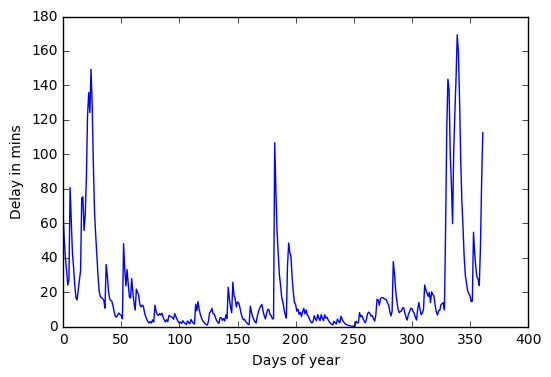

In [7]:
plt.show()

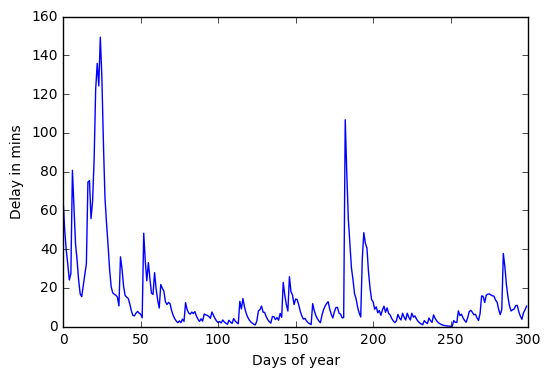

In [8]:
plt.plot(smoothed_dtime[0:300])
plt.xlabel('Days of year')
plt.ylabel('Delay in mins')
plt.show()

In [9]:

rng = pd.date_range('1/1/2016', periods=len(smoothed_dtime), freq='D')


In [10]:
df = pd.Series(smoothed_dtime, index=rng)

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

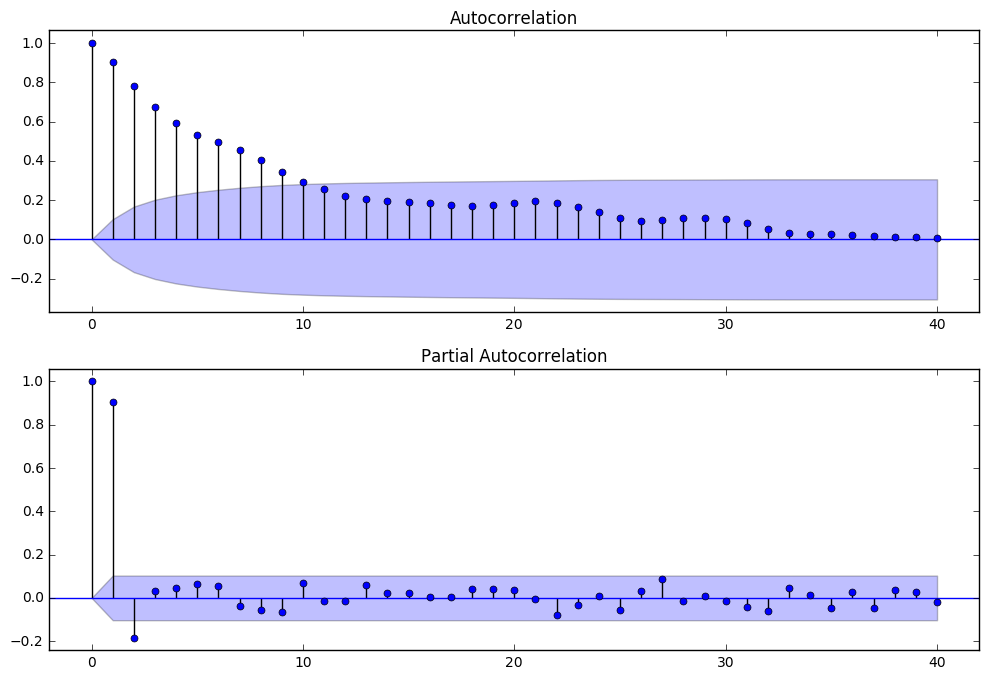

In [12]:
plt.show()

In [13]:
arma_mod28 = sm.tsa.ARMA(df, (3,0)).fit()
print(arma_mod28.aic, arma_mod28.bic, arma_mod28.hqic)

2808.04849639 2827.50671745 2815.78384751


C:\Users\New User\Anaconda2\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)
C:\Users\New User\Anaconda2\lib\site-packages\statsmodels\tsa\arima_model.py:1724: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


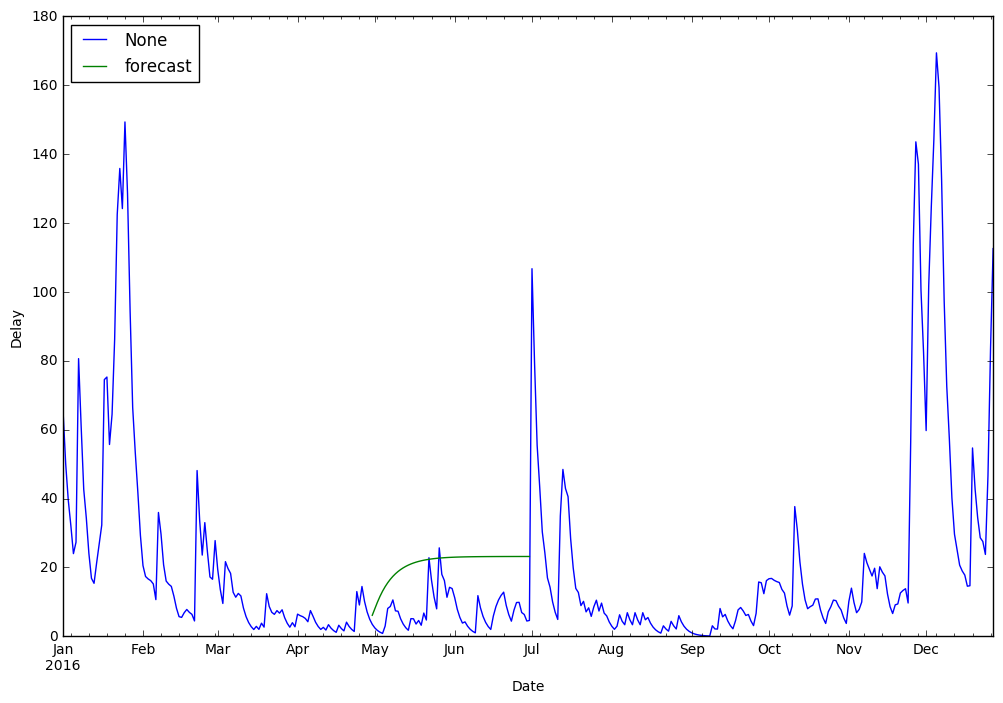

In [14]:
predict_delays = arma_mod28.predict('2016-04-30', '2016-06-30', dynamic=True)
fig, ax = plt.subplots(figsize=(12, 8))
ax = df.ix['2016-01-01':].plot(ax=ax)
fig = arma_mod28.plot_predict('2016-04-30', '2016-06-30', dynamic=True, ax=ax, plot_insample=False)
plt.xlabel('Date')
plt.ylabel('Delay')
plt.show()

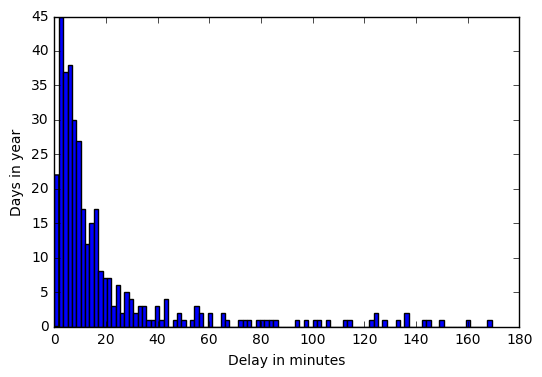

In [15]:
n,x,c = plt.hist(df, 100, normed=0)
plt.xlabel('Delay in minutes')
plt.ylabel('Days in year')
plt.show()

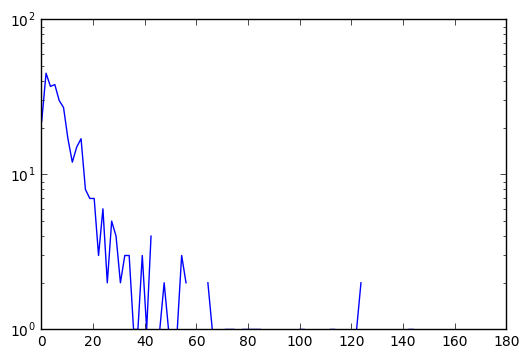

In [16]:
plt.semilogy(x[0:100],n)
plt.show()

In [17]:
def model(t, a, b):
   return a*np.exp(-b*t)

In [18]:
y = model(30, 2, 3)
y

1.6388025247981029e-39

In [19]:
from scipy.stats import expon
param = expon.fit(n)
param

(-5.3180528516452254e-10, 3.6199556891770173)

In [23]:
plt.plot(x[0:100], expon.pdf(x[0:100], 0 , 4))
n,x,c = plt.hist(df, 100, normed=1)
plt.bar(x[0:100],n)
plt.xlabel('Delay')
plt.ylabel('Days')
plt.savefig('delay.png')